In [12]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pymer4.models import Lmer

from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')


## Load Data

Data is select subset from original `sleepstudy` data set which can be [found here](https://rdrr.io/cran/lme4/man/sleepstudy.html) or in the **data folder**

This subset was solely used for illustrative purposes

In [2]:
sleepstudy = pd.read_csv('../data/sleepstudy_subset.csv')
sleepstudy.Subject = sleepstudy.Subject.astype('str')

In [3]:
sleepstudy.head()

,Reaction,Days,Subject
0,222.7339,0,309
1,205.2658,1,309
2,202.9778,2,309
3,204.7070,3,309
4,207.7161,4,309


## Standard Linear Regression

Using `sklearn` and `LinearRegression`

In [3]:
X = sleepstudy.Days.values.reshape(-1,1)
y = sleepstudy.Reaction.values

In [4]:
# Fit sklearn model
lm = LinearRegression()
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
# create start,end points of abline
y0 = lm.intercept_ + X.min()*lm.coef_
y1 = lm.intercept_ + X.max()*lm.coef_

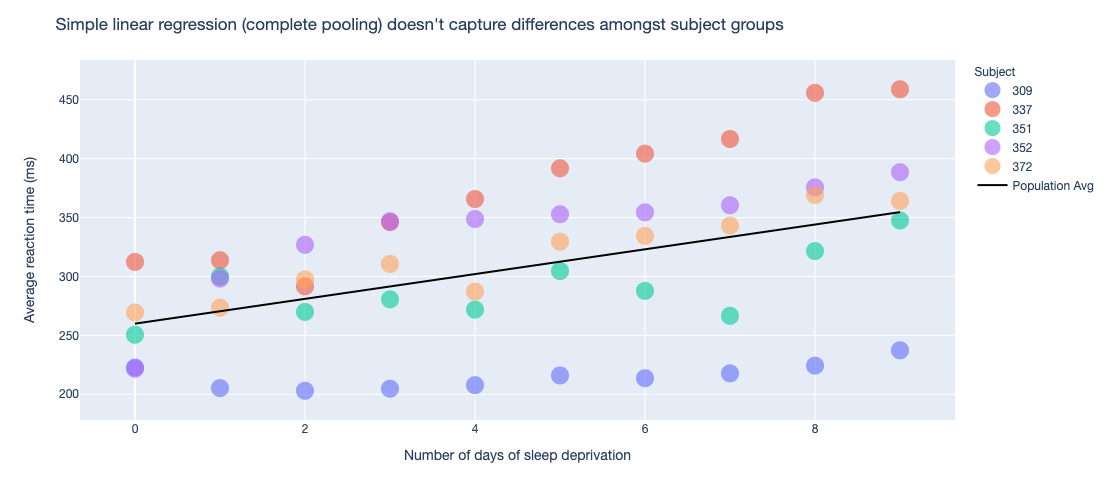

In [9]:
# plot with plotly
fig = px.scatter(sleepstudy, x='Days', y='Reaction', color='Subject')

fig.update_traces(marker=dict(size=18, opacity=0.6),
                  selector=dict(mode='markers'))

fig.add_trace(go.Scatter(x=[X.min(), X.max()], y=np.hstack([y0, y1]), mode='lines', 
                         name="Population Avg", 
                         marker=dict(color='black')))

fig.update_layout(autosize=False,
                  width=1000,
                  height=500,
                 title="Simple linear regression (complete pooling) doesn't capture differences amongst subject groups",
                    xaxis_title="Number of days of sleep deprivation",
                 yaxis_title="Average reaction time (ms)",
                  font=dict(
                      family="Helvetica Neue"))
fig.show()

## Random Intercept Regression (varying-intercept model)

Here we model different initial reaction delay times per subject, but leave the slope constant for all subjects

I used both the `statsmodels` and `pymer4` packages two show some ways of fitting these models, but there are other options available (e.g. using dummy variables to assign group correspondence in a linear regression).

The `statsmodels` package provides some modeling flexibility (i.e. not many paramaters/options you can adjust). **Compared to `pymer4` which leverages the `lme4` R package which works quite well for mixed effects modeling and provides greater option/parameter adjustment options**


### Statsmodels

In [8]:
statm_intercept = smf.mixedlm("Reaction ~ 1 + Days ", sleepstudy, groups='Subject')
vint_model = statm_intercept.fit()

In [9]:
print(vint_model.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Reaction 
No. Observations:   50      Method:             REML     
No. Groups:         5       Scale:              611.8606 
Min. group size:    10      Log-Likelihood:     -235.2315
Max. group size:    10      Converged:          Yes      
Mean group size:    10.0                                 
---------------------------------------------------------
             Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept    259.945   27.451 9.470 0.000 206.142 313.747
Days          10.517    1.218 8.635 0.000   8.130  12.904
Subject Var 3556.310  107.986                            



In [10]:
pd.DataFrame(vint_model.random_effects).T

,Subject
309,-90.482163
337,67.291384
351,-16.883650
352,29.639709
372,10.434719


### Pymer4

**You'll need to make sure you have R installed with the `lme4` and `lmerTest` packages installed**

In [14]:
pymer_intercept = Lmer('Reaction ~ 1 + Days + (1|Subject)', data=sleepstudy)
print(pymer_intercept.fit())

Formula: Reaction~1+Days+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'Subject': 5.0}

Log-likelihood: -235.232 	 AIC: 470.463

Random effects:

Empty DataFrame
Columns: [Name, Var, Std]
Index: []

                    IV1            IV2    Corr
Subject     (Intercept)  NA_character_  59.641
Residual  NA_character_  NA_character_  24.736

Fixed effects:

             Estimate   2.5_ci  97.5_ci      SE      DF  T-stat  P-val  Sig
(Intercept)   259.945  206.137  313.752  27.453   4.338   9.469    0.0  ***
Days           10.517    8.130   12.904   1.218  44.000   8.636    0.0  ***


In [15]:
# (as of this version) gets fixed + random effects (to get only fixed effects use .coefs and only random effects get .ranef)
pymer_intercept.fixef

,(Intercept),Days
309,169.462067,10.517176
337,327.236243,10.517176
351,243.060873,10.517176
352,289.584418,10.517176
372,270.379352,10.517176


In [13]:
pymer_intercept.ranef

,(Intercept)
309,-90.482526
337,67.291655
351,-16.883718
352,29.639828
372,10.434761


### Plot

In [16]:
rint_df = pymer_intercept.fixef.copy() 
rint_df.Days = rint_df.Days*9

rint_df = rint_df.sum(1)

In [17]:
# creating df to plot
df = pd.DataFrame([pymer_intercept.fixef['(Intercept)'], rint_df], index=[0, 9]).T
df.reset_index(inplace=True)

In [18]:
df_melt = df.melt(id_vars='index', var_name='Days', value_name='Reaction')

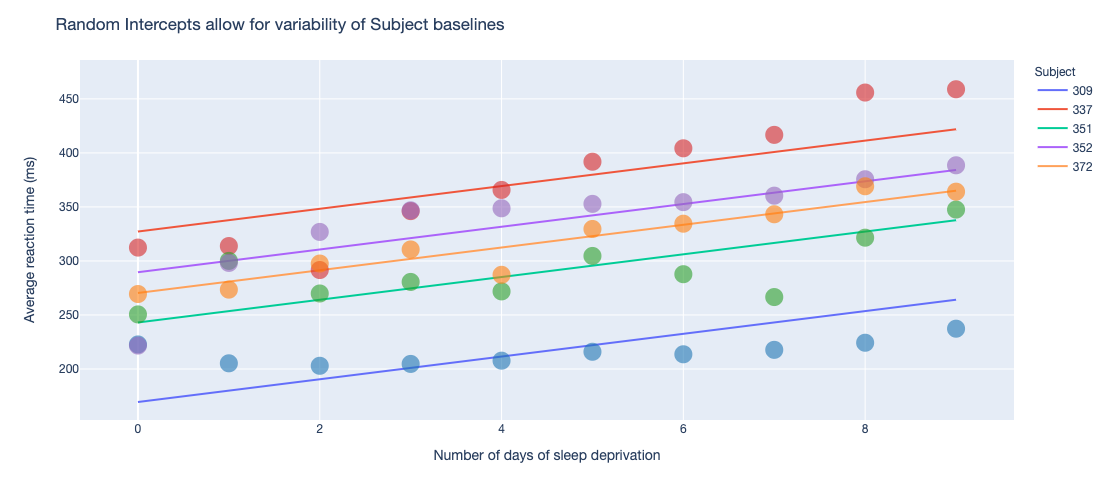

In [26]:
# plot with plotly
fig2 = px.line(df_melt, x='Days', y='Reaction', color='index')

# add individual scatter points
colors= ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']
for i, subj in enumerate(sleepstudy.Subject.unique()):
    subj_scatter = sleepstudy[sleepstudy['Subject'].str.contains(subj)]
    
    fig2.add_trace(go.Scatter(x=subj_scatter['Days'].values, y=subj_scatter['Reaction'].values, 
                              mode='markers', 
                              marker=dict(color=colors[i]),
                              showlegend=False))

fig2.update_traces(marker=dict(size=18, opacity=0.6),
                  selector=dict(mode='markers'))

fig2.update_layout(autosize=False,
                  width=1000,
                  height=500,
                 title="Random Intercepts allow for Subject baselines to vary",
                    xaxis_title="Number of days of sleep deprivation",
                 yaxis_title="Average reaction time (ms)",
                 legend_title_text='Subject',
                  font=dict(
                      family="Helvetica Neue"))
fig2.show()

## Random Slope Regression (varying-slope model)

Using `pymer4` and `statsmodels` 

In [18]:
statm_slope = smf.mixedlm("Reaction ~ Days ", sleepstudy, re_formula='0+Days', groups='Subject')
vslope_model = statm_slope.fit()

In [19]:
print(vslope_model.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Reaction 
No. Observations: 50      Method:             REML     
No. Groups:       5       Scale:              577.6908 
Min. group size:  10      Log-Likelihood:     -233.9884
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept 259.945    6.318 41.146 0.000 247.562 272.327
Days       10.517    5.162  2.037 0.042   0.399  20.635
Days Var  126.251    3.942                             



In [20]:
pd.DataFrame(vslope_model.random_effects).T

,Days
309,-16.654780
337,13.061130
351,-3.832294
352,5.554014
372,1.871929


### Pymer4

In [21]:
pymer_slope = Lmer('Reaction ~ 1+  Days + (0 + Days|Subject)', data=sleepstudy)
print(pymer_slope.fit())

Formula: Reaction~1+Days+(0+Days|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'Subject': 5.0}

Log-likelihood: -233.988 	 AIC: 467.977

Random effects:

Empty DataFrame
Columns: [Name, Var, Std]
Index: []

                    IV1            IV2    Corr
Subject            Days  NA_character_  11.236
Residual  NA_character_  NA_character_  24.035

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   259.945  247.562  272.327  6.318  44.000  41.145  0.000  ***
Days           10.517    0.399   20.635  5.162   4.316   2.037  0.106     


In [22]:
pymer_slope.ranef # same random effects and values as in statsmodels

,Days
309,-16.654774
337,13.061126
351,-3.832293
352,5.554013
372,1.871928


### Plot

In [22]:
# combining fixed and random intercept values
rslope_df = pymer_slope.fixef.copy()
rslope_df.Days = (rslope_df.Days + pymer_slope.ranef.Days)*9

rslope_df = rslope_df.sum(1)

In [23]:
# creating df to plot
df2 = pd.DataFrame([pymer_slope.fixef['(Intercept)'],rslope_df], index=[0, 9]).T
df2.reset_index(inplace=True)

In [24]:
df_melt2 = df2.melt(id_vars='index', var_name='Days', value_name='Reaction')

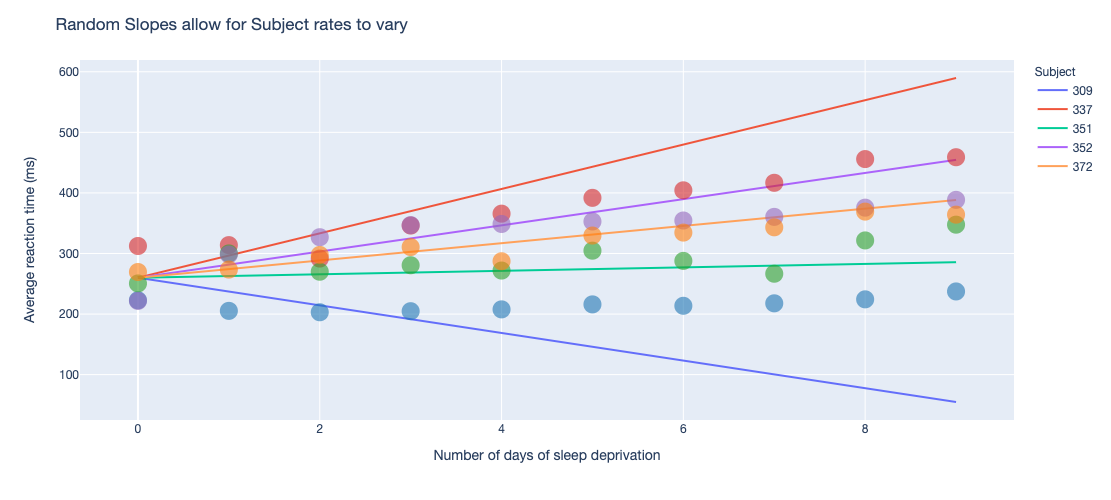

In [27]:
# plot with plotly
fig3 = px.line(df_melt2, x='Days', y='Reaction', color='index')

# add individual scatter points
colors= ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']
for i, subj in enumerate(sleepstudy.Subject.unique()):
    subj_scatter = sleepstudy[sleepstudy['Subject'].str.contains(subj)]
    
    fig3.add_trace(go.Scatter(x=subj_scatter['Days'].values, y=subj_scatter['Reaction'].values, 
                              mode='markers', 
                              marker=dict(color=colors[i]),
                              showlegend=False))

fig3.update_traces(marker=dict(size=18, opacity=0.6),
                  selector=dict(mode='markers'))

fig3.update_layout(autosize=False,
                  width=1000,
                  height=500,
                 title="Random Slopes allow for Subject rates to vary",
                    xaxis_title="Number of days of sleep deprivation",
                 yaxis_title="Average reaction time (ms)",
                 legend_title_text='Subject',
                  font=dict(
                      family="Helvetica Neue"))
fig3.show()

## Random Intercept + Slope Regression (varying-intercept, varying-slope model)
Here we use both `statsmodels` and `pymer`

#### Statsmodels

In [27]:
statm_slope_intercept = smf.mixedlm("Reaction ~ Days ", sleepstudy, re_formula='1+Days', groups='Subject')
vslope_int_model = statm_slope_intercept.fit()

In [28]:
print(vslope_int_model.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Reaction 
No. Observations:     50         Method:                REML     
No. Groups:           5          Scale:                 299.1811 
Min. group size:      10         Log-Likelihood:        -221.5715
Max. group size:      10         Converged:             No       
Mean group size:      10.0                                       
-----------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           259.945   17.416 14.926 0.000 225.810 294.079
Days                 10.517    3.601  2.921 0.003   3.460  17.574
Subject Var        1413.224  149.003                             
Subject x Days Cov  263.681   21.665                             
Days Var             61.193    9.523                             



In [29]:
pd.DataFrame(vslope_int_model.random_effects).T

,Subject,Days
309,-50.203548,-9.025215
337,32.970388,7.911005
351,-4.681351,-2.971082
352,15.809496,3.131080
372,6.105014,0.954213


#### Pymer4

In [28]:
pymer_slope_intercept = Lmer('Reaction ~ 1 + Days + (1 + Days|Subject)', data=sleepstudy)
print(pymer_slope_intercept.fit())

boundary (singular) fit: see ?isSingular 

Formula: Reaction~1+Days+(1+Days|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'Subject': 5.0}

Log-likelihood: -220.731 	 AIC: 441.462

Random effects:

Empty DataFrame
Columns: [Name, Var, Std]
Index: []

                    IV1            IV2    Corr
Subject     (Intercept)  NA_character_  31.592
Subject            Days  NA_character_   6.290
Subject     (Intercept)           Days   1.000
Residual  NA_character_  NA_character_  17.721

Fixed effects:

             Estimate   2.5_ci  97.5_ci      SE     DF  T-stat  P-val  Sig
(Intercept)   259.945  230.787  289.102  14.877  4.034  17.473  0.000  ***
Days           10.517    4.745   16.289   2.945  4.027   3.571  0.023    *


In [31]:
pymer_slope_intercept.ranef

,(Intercept),Days
309,-47.573265,-9.471626
337,36.364599,7.240030
351,-9.933755,-1.977767
352,15.727218,3.131219
372,5.415203,1.078143


### Plot

In [29]:
# combining fixed and random intercept values
rint_slope_df = pymer_slope_intercept.fixef.copy()
rint_slope_df.Days = rint_slope_df.Days*9
rint_slope_df = rint_slope_df.sum(1)

In [30]:
# creating df to plot
df_slope_int = pd.DataFrame([pymer_slope_intercept.fixef['(Intercept)'],rint_slope_df], index=[0, 9]).T
df_slope_int.reset_index(inplace=True)

In [31]:
df_slope_int_melt = df_slope_int.melt(id_vars='index', var_name='Days', value_name='Reaction')

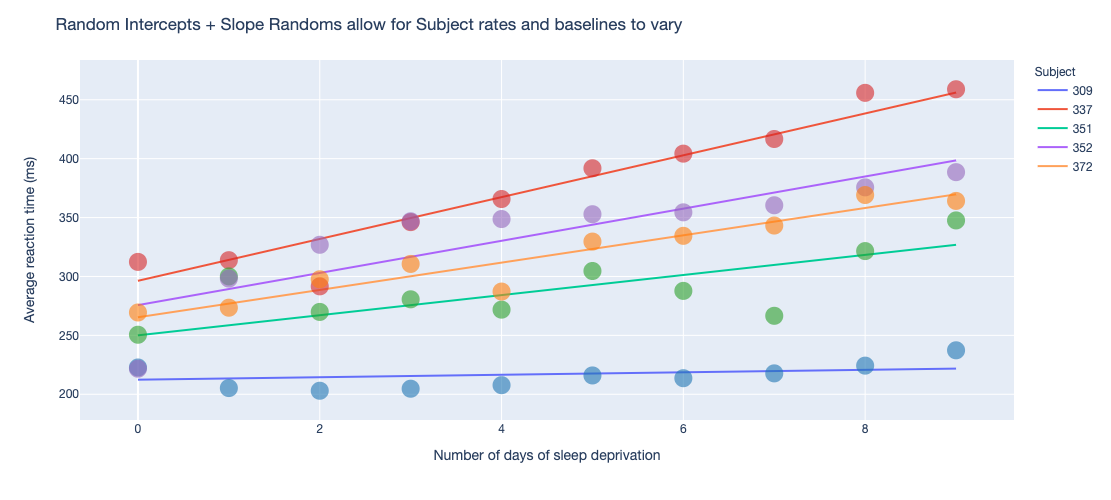

In [33]:
# plot with plotly
fig4 = px.line(df_slope_int_melt, x='Days', y='Reaction', color='index')

# add individual scatter points
colors= ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']
for i, subj in enumerate(sleepstudy.Subject.unique()):
    subj_scatter = sleepstudy[sleepstudy['Subject'].str.contains(subj)]
    
    fig4.add_trace(go.Scatter(x=subj_scatter['Days'].values, y=subj_scatter['Reaction'].values, 
                              mode='markers', 
                              marker=dict(color=colors[i]),
                              showlegend=False))

fig4.update_traces(marker=dict(size=18, opacity=0.6),
                  selector=dict(mode='markers'))

fig4.update_layout(autosize=False,
                  width=1000,
                  height=500,
                 title="Random Intercepts + Slope Randoms allow for Subject rates and baselines to vary",
                    xaxis_title="Number of days of sleep deprivation",
                 yaxis_title="Average reaction time (ms)",
                 legend_title_text='Subject',
                  font=dict(
                      family="Helvetica Neue"))
fig4.show()

# Additional Example (No pooling)

This refers to a situation where each individual trendline **only considers** those points within the group when fitting the Regression model. This is also known as a **no pooling** model

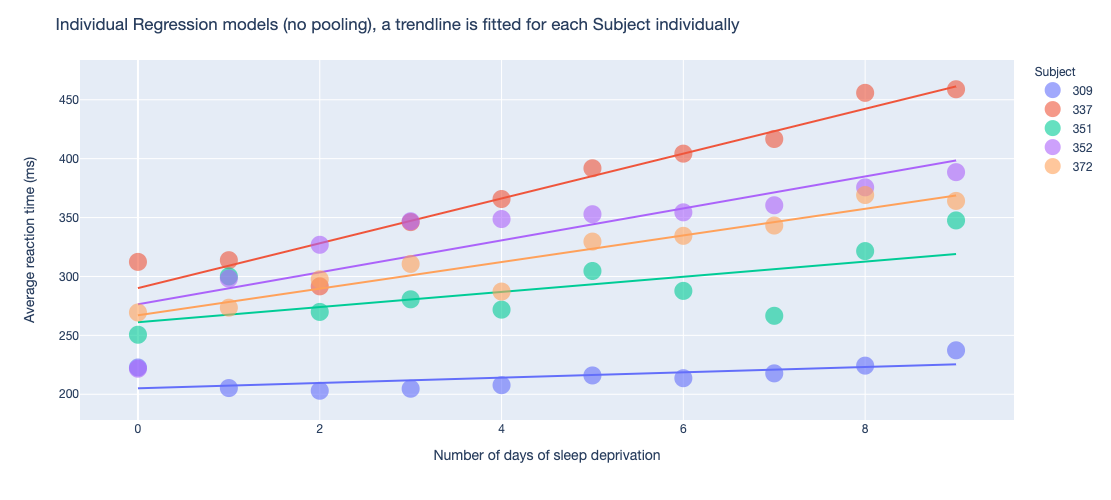

In [36]:
# plotly express has a 'trendline' option which fits individual ols lines (i.e. a no pooling model)
fig5 = px.scatter(sleepstudy, x='Days', y='Reaction', color='Subject', trendline='ols')

fig5.update_traces(marker=dict(size=18, opacity=0.6),
                  selector=dict(mode='markers'))

fig5.update_layout(autosize=False,
                  width=1000,
                  height=500,
                 title="Individual Regression models (no pooling), a trendline is fitted for each Subject individually",
                    xaxis_title="Number of days of sleep deprivation",
                 yaxis_title="Average reaction time (ms)",
                 legend_title_text='Subject',
                  font=dict(
                      family="Helvetica Neue"))
fig5.show()